In [81]:
import pandas as pd

In [82]:
#loading datasets
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')

In [83]:
predefined_departments = pd.read_csv('department_groups.csv')

TODO: finish implementing required functionality, that given a list of department fields, *make_submission* function would return mapped department group for each department in the list. We will use this function to get your predictions for our private test set.

In [84]:
#checking structure of data and if there are any missing values in given datasets
print(train_set.head())
print(test_set.head())
print(train_set.isnull().any())
print(test_set.isnull().any())

                 Department Department Group
0               support muc       it support
1             new york city         regional
2          support services       it support
3  10612 - support services       it support
4       syseng uk intc usdc         regional
                    Department Department Group
0    manufacturing engineering              r&d
1     post market surveillance          finance
2  accounts payable/receivable          finance
3          information systems              r&d
4         is service & support       it support
Department          False
Department Group    False
dtype: bool
Department          False
Department Group    False
dtype: bool


In [85]:
#There are no missing values. Expect this in the private test set as well

In [86]:
#checking if there are examples of every department group
print(train_set.columns)
print(train_set["Department Group"].unique())
print(predefined_departments)

Index(['Department', 'Department Group'], dtype='object')
['it support' 'regional' 'operations' 'audit' 'human resource' 'r&d'
 'finance' 'consulting' 'marketing' 'sales' 'legal' 'it security'
 'business' 'executive']
   Department Groups
0         operations
1           regional
2         it support
3                r&d
4            finance
5     human resource
6              audit
7           business
8              legal
9         consulting
10         executive
11       it security
12         marketing
13             sales


In [87]:
#there are examples of every department group in the training set

In [88]:
#Converting categories of the training set into integer numbers
train_set["group_id"]=train_set["Department Group"].factorize()[0]

#Creating dictionaries to easily convert between the names of the categories and integer numbers assigned to them
group_id_train = train_set[['Department Group', 'group_id']].drop_duplicates().sort_values('group_id')
group_to_id = dict(group_id_train.values)
id_to_group = dict(group_id_train[['group_id', 'Department Group']].values)

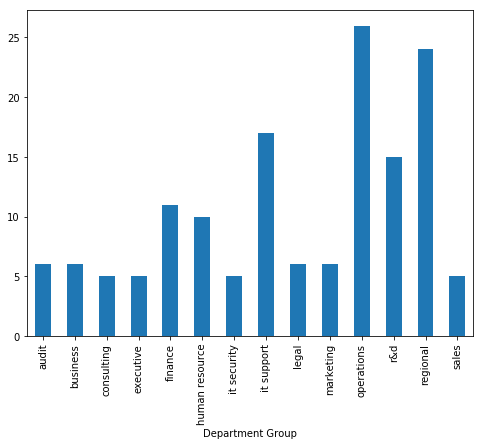

In [89]:
#checking what training data is made of
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train_set.groupby('Department Group').Department.count().plot.bar(ylim=0)
plt.show()

In [90]:
#A very uneven number of training data. This will make predictions biased. Correct methods should be used to solve this. 
#Oversampling(undersampling) is one option

In [91]:
#Algorithms do not directly understand words and so they have to be converted numerical vectors. 
#One of the methods is using TF-IDF vector technique, which gives an importance of the words, which appear in the text.
#Importance depends on how often words are used, but does not depend on the order of words
from sklearn.feature_extraction.text import TfidfVectorizer

#ngram_range=(1,2) shows that it is chosen to count importance not only on single words, but on every two near by words
#lowercase = True, is used that one capital letter in the word would not make it as a different word
#stop_words='english', removes common words like 'the' or 'a', which would be just a noise in this task
#TdidfVectorizer will clean the data quite a bit, but with more time I would make sure manually that data is clean
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), lowercase = True, stop_words='english')
features = tfidf.fit_transform(train_set.Department).toarray()

#saving 'group_id' for easier reference
labels = train_set.group_id

In [92]:
#using feature_selection.chi2 to see what words are the most common for which department group

from sklearn.feature_selection import chi2
import numpy as np
N = 2
print()
for Department_group, group_id in sorted(group_to_id.items()):
  features_chi2 = chi2(features, labels == group_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Department_group))
  print("  . Most correlated unigrams:. {}".format('. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:. {}".format('. '.join(bigrams[-N:])))


# 'audit':
  . Most correlated unigrams:. nevada. audit
  . Most correlated bigrams:. assurance cluster. audit assurance
# 'business':
  . Most correlated unigrams:. govt. retail
  . Most correlated bigrams:. national govt. customer development
# 'consulting':
  . Most correlated unigrams:. technology. consulting
  . Most correlated bigrams:. consulting power. consulting technology
# 'executive':
  . Most correlated unigrams:. head. ceo
  . Most correlated bigrams:. ceo office. head business
# 'finance':
  . Most correlated unigrams:. valuations. finance
  . Most correlated bigrams:. finance acounting. finance accounting
# 'human resource':
  . Most correlated unigrams:. human. hr
  . Most correlated bigrams:. hr mgmt. human resources
# 'it security':
  . Most correlated unigrams:. fraud. security
  . Most correlated bigrams:. ist data. fraud detection
# 'it support':
  . Most correlated unigrams:. training. support
  . Most correlated bigrams:. team support. support services
# 'legal

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

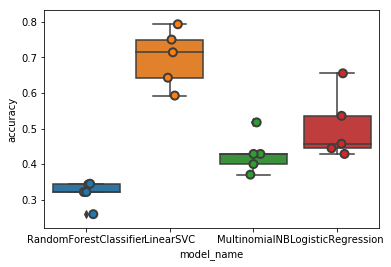

In [93]:
#Now different models will be used to correctly predict the what words represent which department group 

#One of the best algorithms to start with for word classification is Naive Bayes Classifier. 
#It is a probabilistic algorithm, which makes an assumption that the occurrence of a certain feature is independent of the occurrence of other features
#It multiplies probabilities of words for every category and chooses an answer with the biggest probability


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
#CV=5 is a technique called cross-validation. It divides data set into 5 parts. 5 models are made and averaged with validation data being a different 20% percent each time of the  whole train set 
CV = 5
cv_data = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_data = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

#plotting results of the models and choosing the best one
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_data)
sns.stripplot(x='model_name', y='accuracy', data=cv_data, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [94]:
#Getting precise values of the moels
cv_data.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.698568
LogisticRegression        0.504209
MultinomialNB             0.428951
RandomForestClassifier    0.317960
Name: accuracy, dtype: float64

In [95]:
#As it can be seen from the accuracy data, 
#LinearSVC model is the most precise and it will be used further on to get better results after training with all training data without cross-validation
model = LinearSVC()
model.fit(features, labels)

#test set will be used to see how accurate the model became and so it has to be prepared for it
test_set["group_id"] = [group_to_id[department] for department in test_set['Department Group']]
test_labels = test_set.group_id
test_features = tfidf.transform(test_set["Department"]).toarray()

# Use the model to predict department groups
y_pred = model.predict(test_features)

#finding the accuracy of the model
from sklearn.metrics import accuracy_score
print("Accuracy of the model on test data: ",accuracy_score(test_labels,y_pred))

Accuracy of the model on test data:  0.696969696969697


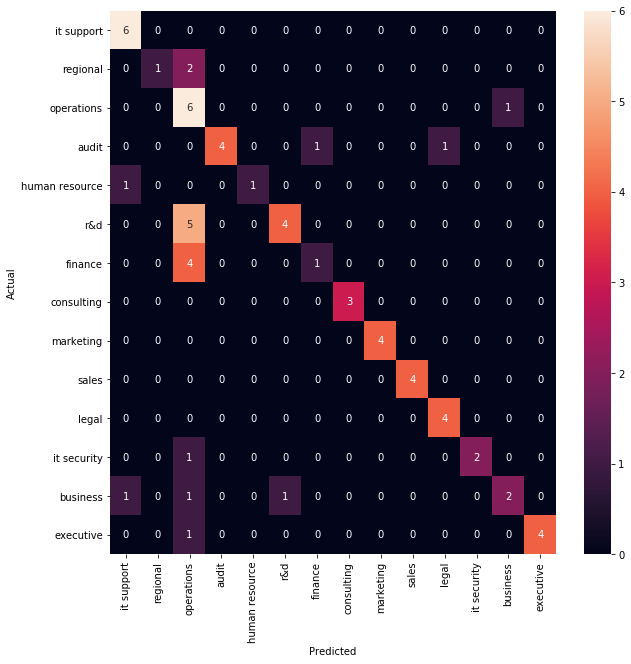

In [96]:
#It looks that data regularised very well and did not overfit, as acurracy on the test set is very close to the accuracy on the training set
#To see what are the mistakes of the model, the confusion matrix is built
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=group_id_train["Department Group"].values, yticklabels=group_id_train["Department Group"].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [80]:
#It can be seen that as predicted model is biased and predicts 'operations' most often.
#It is also visible that most of the mistakes comes from 'R&D' and 'finance' predictions and it should be checked how data looks in train_set and test_set

print("Data containing 'r&d' in the training set:")
for i in range(len(train_set)):
    if ((train_set['Department'][i].find("r&d") != -1) or (train_set['Department Group'][i].find("r&d") != -1)): print("\t",train_set['Department'][i],"   ",train_set['Department Group'][i])
        
print("\nData containing 'r&d' in the test set:")
for i in range(len(test_set)):
    if ((test_set['Department'][i].find("r&d") != -1) or (test_set['Department Group'][i].find("r&d") != -1)): print("\t",test_set['Department'][i],"   ",test_set['Department Group'][i])
        
print("\nData containing 'finance' in the training set:")
for i in range(len(train_set)):
    if train_set['Department Group'][i].find("finance") != -1: print("\t",train_set['Department'][i])
        
print("\nData containing 'finance' in the test set:")
for i in range(len(test_set)):
    if test_set['Department Group'][i].find("finance") != -1: print("\t",test_set['Department'][i])


Data containing 'r&d' in the training set:
	 r&d - medsurg     r&d
	 endo r&d     r&d
	 research and development     r&d
	 research & development     r&d
	 manufacturing     r&d
	   data science and business intelligence     r&d
	 beaconsfield res dev     r&d
	 r&d video     r&d
	 research & technology developement     r&d
	 r&d- imt     r&d
	 business intelligence     r&d
	 it projects     r&d
	 r&d communication     r&d
	 research     r&d
	 global data center services     r&d

Data containing 'r&d' in the test set:
	 manufacturing engineering     r&d
	 information systems     r&d
	 r&d i&s     r&d
	 inf data center services     r&d
	 r&d cmf     r&d
	 inf data center services     r&d
	 r&d integration     r&d
	 r&d trit     r&d
	 product development     r&d

Data containing 'finance' in the training set:
	 investment casting
	 finance ;
	 finance & acounting
	 finance and accounting
	 shareholder accounting
	 valuations
	 risk mgmt
	 financial
	 risk management (8645231)
	 finance ; 

In [97]:
#Data shows that finance was not predicted correctly because of different keywords in train and test datasets. It could be fixed only by a bigger training dataset
#On the other hand, it can be seen that training set has 'r&d' as a word to be trained for it, but most probably does not detect it test set as '&' is not a letter and is lost during TfidfVectorization. This error consists around 50% of r&d cases and should be hard coded into search

y_pred_strings = [id_to_group[department_group] for department_group in y_pred]
for i in range(len(y_pred_strings)):
    if test_set['Department'][i].find("r&d") != -1: y_pred_strings[i]="r&d" 
    
print("Final accuracy of the model % 12.2f" % accuracy_score(test_set['Department Group'],y_pred_strings))

Final accuracy of the model         0.76


In [98]:
#making functions to easily use any file to get predictions of the Department Groups
def make_submission(departments):
    #TODO implement specified functionality
    features_for_test = tfidf.transform(departments).toarray()
    predictions = model.predict(features_for_test)
    predictions = [id_to_group[department_group] for department_group in predictions]
    
    #Hard coding missing "r&d"
    for i in range(len(predictions)):
        if departments[i].find("r&d") != -1: predictions[i]="r&d" 
    return predictions

predictions = make_submission(test_set['Department'])
pd.DataFrame({'Department': test_set['Department'], 'Department Group Prediction': predictions}).to_csv('predictions.csv', 
                                                                                                        index=False)

In [99]:
#Future improvement ideas
#Things to do with more time:
#1) Check if data was correctly cleaned from:
#    a)possesive pronouns
#    b)punctuation signs
#    c)special characters
#2) Spend more time trying to get better parameters for models
#3) Do oversampling (undersampling) of the data
#4) Try state of the art models for text classification
#5) Make sure that data is cleaned properly by TdidfVectorizer
#6) Check more wrong predictions to see if it is possible to fix it. like the one with 'r&d'